In [1]:
import numpy as np 
import pandas as pd
from matplotlib import font_manager as fm, pyplot as plt
helv=fm.FontProperties(fname='helvetica.ttf')
plt.style.use('seaborn-colorblind')
import re

In [2]:
# choose and load dataset
dataset='beta_center_p1e-06'
npc=500
z=np.load('/oak/stanford/groups/mrivas/projects/degas-risk/datasets/train/v2/tsvd/all_'+dataset+
          '_20200506_'+str(npc)+'PCs.npz', allow_pickle=True)

# map phenotype names
with open('/oak/stanford/groups/mrivas/projects/degas-risk/master.20200420.phe.info.tsv', 'r') as i:
    code2phe={line.split()[0]:line.split()[1].replace('_',' ') for line in i}
# capitalize
code2phe={k:v[0].upper()+v[1:] for k,v in code2phe.items()}

# phenotype short names
def short(phe_name):
    repl={'(right)':'(R)', '(left)':'(L)', 
          'Human Cytomegalovirus':'HCMV', # virus abbreviations
          'Human Polyomavirus':'HPyV',
          'Varicella Zoster Virus':'VZV',
          'covariate and statin adjusted':'(adj.)', # biomarker adjustments
          'covariate adjusted':'(adj.)',
          'platelet (thrombocyte)':'thrombocyte',
          'Intra-ocular pressure':'IOP', # standard acronyms
          'bone mineral density ':'', '(BMD)':'BMD',
          'quantitative ultrasound index ':'', '(QUI)':'QUI',
          'Abdominal subcutaneous adipose tissue':'ASAT', ' (ASAT)':'',
          'Forced expiratory volume in 1-second ':'', '(FEV1)':'FEV1',
          'Heart attack/m':'M', ' (BMI)':'',
          ' (natural, before greying)':':', # removing parentheticals
          ' (chronotype)':'',
          ' (menarche)':'',
          ' (blood clot in lung)':'',
          'e only)':'e)', # male/female only traits
          'Best measure':'Best', # brevity edits
          'frequency.':'frequency',
          'Degree bothered by headaches':'Headaches', 
          'Frequency':'Freq.',
          'percentage':'pct.',
          'Number of days/week of':'Weekly',
          'Number of self-reported':'Number of',
          'Vascular/heart problems diagnosed by doctor':'Doctor diagnosed',
          'Volume of grey matter in Intracalcarine Cortex':'Intracalcarine cortical grey matter',
          'Diagnosed with c':'C', # celiac disease or gluten intolerance
          '/ lethargy':'', # tiredness
          'illness, disability or infirmity':'disability / infermity',
          'hay fever, rhinitis or eczema diagnosed':'hay fever, rhinitis or eczema\ndiagnosed',
          'Hearing difficulty/problems with background':'Hearing problems w/background', # noise
          'consuming six or more units of':'binge drinking', # alcohol(ism) traits
          'drunk on a typical drinking day':'typically drunk',
          'feeling guilt or remorse after drinking alcohol in last year':'guilt after drinking',
          'drinking in last year':'drinking',
          'drinking alcohol in last year':'drinking',
          'physical activity':'physical activity\n'
         }
    return re.compile("|".join(map(re.escape, repl.keys()))).sub(lambda match: repl[match.group(0)], phe_name)

# choose phenotypes
phenos=['INI21001','HC326','HC328']

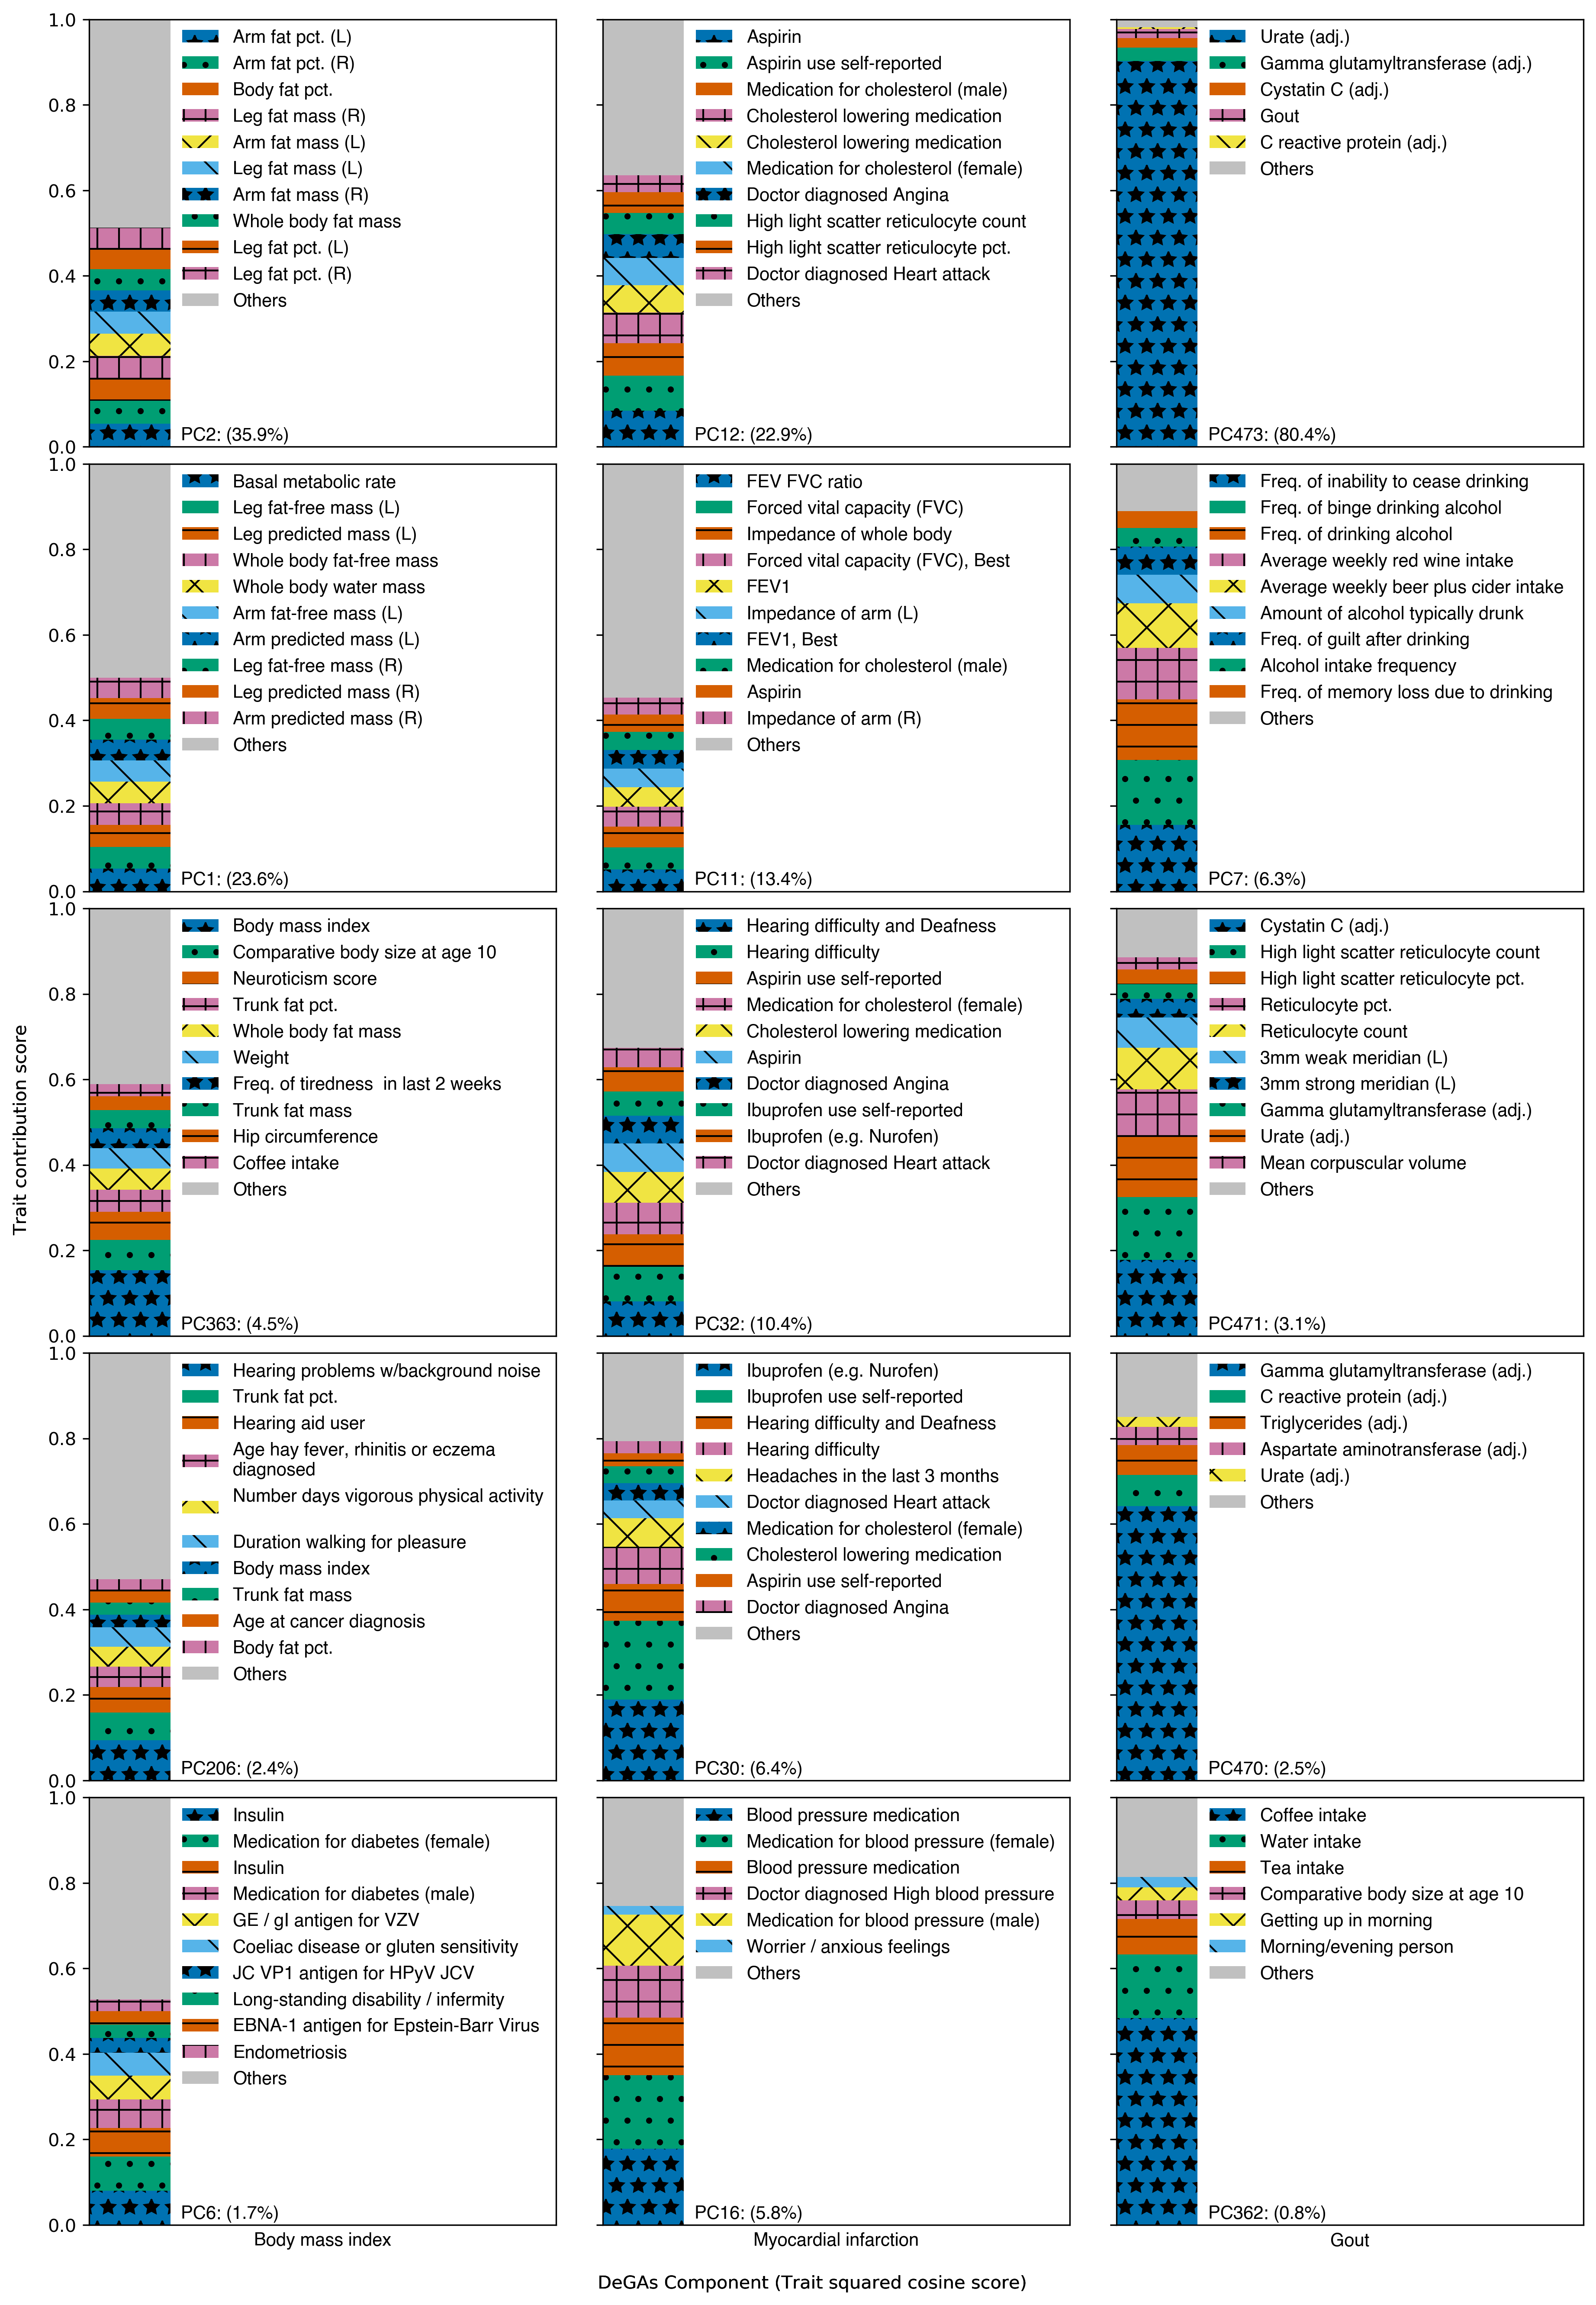

In [4]:
# adjust to use factor score VD rather than V (given W ~ UD(V^T))
V = z['V'] * z['D']

# setup for patterning within stacked barplot
patterns = ('-', '+', 'x', '\\', '*', '.')

# setup figure
k=5 # how many components
fudge=4.5
fs=10 # font size for outer label elements


# loop over traits, top k components
fig=plt.figure(figsize=(fudge*(len(phenos)+0.3), fudge*k), dpi=300)
for phx,phe in enumerate(phenos):
    pix=np.where(z['label_phe_code']==phe)
    for pcx in range(k):
        # setup: figure, which component, traits therein
        ax=fig.add_subplot(k, len(phenos), (phx+1) + len(phenos)*pcx)
        pc=np.argsort(V[pix,:npc]**2).flatten()[-(pcx+1)]
        ranked_phes=np.argsort(V[:,pc]**2)[::-1].flatten()
        # loop over top 10 traits, plot bars if bar above 1%
        for ix,phe_ix in enumerate(ranked_phes[:10]):
            if (z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2) > 0.02 or ix < 5:
                plt.bar([0], [(z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2)], 
                        bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2),
                        label=short(code2phe[z['label_phe_code'][phe_ix]]),
                        hatch=patterns[(ix + 4) % len(patterns) ]
                        )
            else: ix-=1; break
        ix+=1
        # add grey bar on top
        plt.bar([0], [1-(np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2))],
                bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2), 
                color='silver', label='Others')
        # adjust figure ticks/limits; add labels
        plt.ylim(0,1); plt.xlim(0,2.3)
        plt.xticks([],[])
        ax.text(0.453, 0.015, 'PC{0}: ({1:.1f}%)'.format(pc+1, 100*((V[pix,pc]**2)/np.sum(V[pix,:]**2))[0][0]), 
                   horizontalalignment='left', fontproperties=helv, fontsize=fs)
        if pcx == k - 1:
            plt.xlabel(short(code2phe[phe]), fontproperties=helv, fontsize=fs)
            # if pcx==0:
            #    ax.text(-.35, 0.95, chr(65+phx), fontproperties=helv, fontsize=20)
        if phx != 0:
            ax.set_yticklabels(['' for _ in ax.get_yticks()])
        lgd=plt.legend(loc='upper left', bbox_to_anchor=(0.165, 1.015), frameon=False, fontsize=6, prop=helv)

    # add labels for the entire figure
    fig.text(0.5, 0.105, 'DeGAs Component (Trait squared cosine score)', ha='center', va='center', fontsize=fs)
    fig.text(0.09, 0.5, 'Trait contribution score', ha='center', va='center', rotation=90, fontsize=fs)
    fig.subplots_adjust(hspace=0.04, wspace=0.1)

# done
plt.savefig('pdfs/fig3.pdf', bbox_inches='tight')
plt.show()